In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from picard import amari_distance
import lingam
from lingam.utils import make_dot
from shica import shica_ml

# sample data

In [6]:
# parameters
m = 5
p = 4
n = 1000
nb_gaussian_sources = 0
random_state = 2
rng = np.random.RandomState(random_state)

In [7]:
# function that samples data according to our model
# we use similar parameters as in Fig. 2 of the ShICA paper
def sample_data(m, p, n, nb_gaussian_sources=0, rng=None):
    # sources
    S_ng = rng.laplace(size=(p-nb_gaussian_sources, n))
    S_g = rng.normal(size=(nb_gaussian_sources, n))
    S = np.vstack((S_ng, S_g))

    # noise
    sigmas = np.ones((m, p)) * 1 / 2
    if nb_gaussian_sources != 0:
        sigmas[:, -nb_gaussian_sources:] = rng.uniform(size=(m, nb_gaussian_sources))
    N = rng.normal(scale=sigmas[:, :, np.newaxis], size=(m, p, n))

    # causal effect matrices
    T = rng.normal(size=(m, p, p))
    for i in range(m):
        T[i][np.triu_indices(p, k=0)] = 0  # set the strictly upper triangular part to 0

    # causal order
    P = np.eye(p)
    rng.shuffle(P)

    # mixing matrices
    A = P.T @ np.linalg.inv(np.eye(p) - T) @ P

    # observations
    # X = [(Ai @ Si).T for Ai, Si in zip(A, S + N)]
    # OR
    X = np.array([Ai @ Si for Ai, Si in zip(A, S + N)])
    # X = list(np.swapaxes(X, 1, 2))
    # AND NOT (!)
    # X = np.array([Ai @ Si for Ai, Si in zip(A, S + N)]).reshape(m, n, p)

    return X, T, P, A

In [8]:
# generate observations X, causal order P, and causal effects T
X, T, P, A = sample_data(m, p, n, nb_gaussian_sources, rng)
order = np.argmax(P, axis=1)
B = P.T @ T @ P

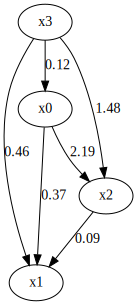

In [57]:
# display true graph
make_dot(B[0])

# LiNGAM

In [58]:
# perform LiNGAM
B_estimates = []
T_estimates = []
P_estimates = []
model = lingam.ICALiNGAM()
for i in range(m):
    model.fit(X[i])    
    # causal order P
    P_estimate = np.eye(p)[model.causal_order_]
    P_estimates.append(P_estimate)
    # causal effect matrix B
    B_estimate = np.array(model._adjacency_matrix)
    B_estimates.append(B_estimate)
    T_estimate = P_estimate @ B_estimate @ P_estimate.T
    T_estimates.append(T_estimate)
B_estimates = np.array(B_estimates)
T_estimates = np.array(T_estimates)
P_estimates = np.array(P_estimates)

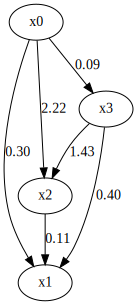

In [59]:
# display estimated graph
make_dot(B_estimates[0])

# error

In [60]:
# errors
W_estimates = np.eye(p) - B_estimates
amari = np.mean([amari_distance(Wi, Ai) for Wi, Ai in zip(W_estimates, A)])
error_P = np.mean([1 - (Pi == P).all() for Pi in P_estimates])
error_T = np.mean((T_estimates - T) ** 2)

if error_P:
    print("There is at least one view for which the causal order P is not retrieved.")
else:
    print("The causal order P is retrieved for all views!")
print(f"Error on causal orders P : {error_P}")
print(f"Error on causal effect matrices T : {error_T}")
print(f"Amari distance : {amari}")

There is at least one view for which the causal order P is not retrieved.
Error on causal orders P : 0.26666666666666666
Error on causal effect matrices T : 0.15776284090039827
Amari distance : 0.003146811013487019


# plot

In [35]:
# plot heat maps of causal effect matrices
def heat_maps_T(T, title_add=""):
    m = len(T)
    fontsize = 18
    fig, axes = plt.subplots(1, m, figsize=(m*5, 5))
    if np.min(T) == np.max(T):
        print("T is equal to a constant.")
        return
    if np.min(T) < 0 and 0 < np.max(T):
        norm = TwoSlopeNorm(vmin=np.min(T), vmax=np.max(T), vcenter=0)
    else:
        norm = TwoSlopeNorm(vmin=np.min(T), vmax=np.max(T), vcenter=(np.min(T)+np.max(T))/2)
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(T[i], norm=norm, cmap="coolwarm")
        ax.set_title(f"View {i}", fontsize=fontsize)
    cbar = fig.colorbar(im, ax=axes, fraction=0.0085, pad=0.015)
    cbar.set_label('Color Scale', fontsize=fontsize)
    fig.suptitle(f"{title_add} causal effect matrices T", fontsize=fontsize)
    fig.supxlabel("components", fontsize=fontsize)
    fig.supylabel("components", fontsize=fontsize, x=0.1)
    plt.show()

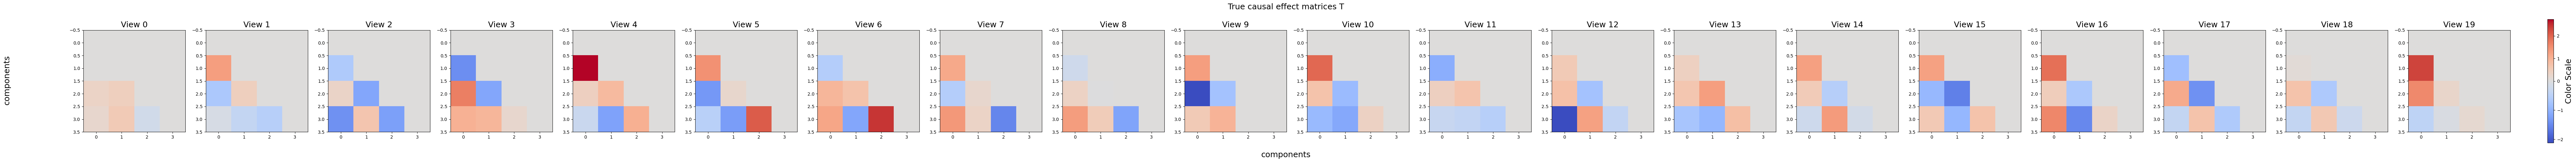

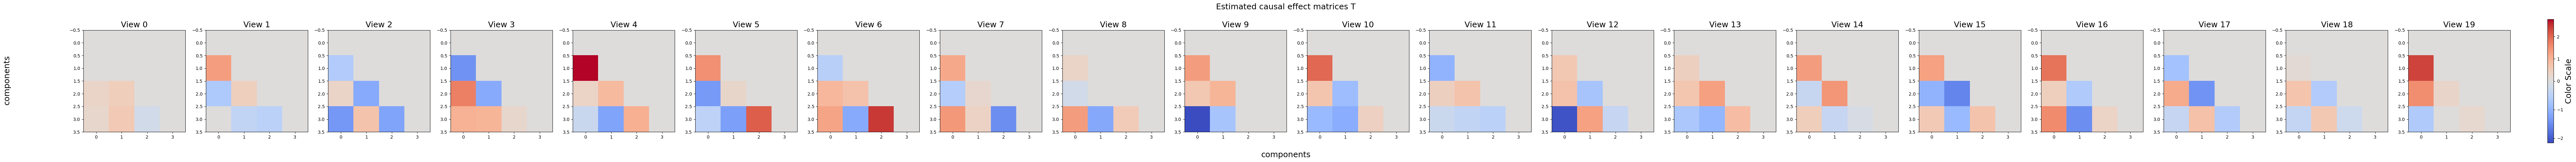

In [36]:
heat_maps_T(T, title_add="True")
heat_maps_T(T_estimates, title_add="Estimated")

# Compare with our method

In [9]:
# ShICA-ML
# W_shica_ml, sigmas_shica_ml, S_shica_ml = shica_ml(np.swapaxes(X, 1, 2))
W_shica_ml, sigmas_shica_ml, S_shica_ml = shica_ml(X)
amari_shica_ml = np.mean([amari_distance(Wi, Ai) for Wi, Ai in zip(W_shica_ml, A)])
amari_shica_ml

0.005068496469102823